In [94]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from collections import namedtuple
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import DataLoader

import os

from PIL import Image

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
data_train_directory = '/content/drive/MyDrive/kì_1_4/Xu_ly_anh/Thay_cuong/gk/Code/int3404-3-simpleORC/data/train'
data_test_directory = '/content/drive/MyDrive/kì_1_4/Xu_ly_anh/Thay_cuong/gk/Code/int3404-3-simpleORC/data/test'
model = '/content/drive/MyDrive/kì_1_4/Xu_ly_anh/Thay_cuong/gk/Code/simpleOCR_trinh/model.pth'

In [76]:
train_name = transforms.Compose([transforms.Resize((256, 256)), transforms.RandomCrop(224, padding=4), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
test_name = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [77]:
#tupple
data = namedtuple('data', ['train', 'test'])
classes = ['highlands', 'others', 'phuclong', 'starbucks']

In [78]:
#hàm chuẩn bị dữ liệu
def prepare_data():
  trainset = torchvision.datasets.ImageFolder(root=data_train_directory,  transform=train_name)      #chứa ảnh train 
  testset = torchvision.datasets.ImageFolder(root=data_test_directory, transform=test_name)             #chứa ảnh test 
  return data(train=trainset, test=testset)         #data: là tupple data[train][test]

In [79]:
#hàm load dữ liệu 
def prepare_loader(datasets):
  train_loader = DataLoader(dataset=datasets.train, batch_size=8, shuffle=True, num_workers=4)
  test_loader = DataLoader(dataset=datasets.test, batch_size=8, shuffle=False, num_workers=4)     #suffer la gi
  return data(train=train_loader, test=test_loader)

In [80]:
#hàm hiển thị ảnh hoá đơn
def imshow(img):
  img = img / 2 + 0.5
  img_to_numpy = img.numpy()
  plt.imshow(np.transpose(img_to_numpy, (1, 2, 0)))
  plt.show()

In [81]:
#hàm train từng epoch
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  model.train()
  running_loss = 0.0
  final_loss = 0.0

  reporting_steps = 10
  step = 0

  #duyệt ảnh và nhãn
  for images, labels in loader:
    step += 1
    images, labels = images.to(device), labels.to(device)   #device là tham số trên
    
    outputs = model(images)                                                        #model là tham số trên
    loss = loss_func(outputs, labels)                                           #loss_func là tham số trên

    #tối ưu 
    optimizer.zero_grad()
    loss.backward()                                 #lan truyền ngược để cập nhật trọng số
    optimizer.step()

    final_loss = loss.item()
    running_loss += final_loss
    if step % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} step {step} average_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0
  
  return final_loss

In [82]:
#hàm kiểm tra epoch
def test_epoch(epoch, model, loader, device):
  ytrue = []
  ypred = []

  with torch.no_grad():
    model.eval()                  #tham so tren

    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)    #dim???

      ytrue += list(labels.cpu().numpy())
      ypred += list(predicted.cpu().numpy())
  return ypred, ytrue


In [83]:
def main():
  PATH = './model.pth'
  class_out = len(classes)  #classes = ['highlands', 'others', 'phuclong', 'starbucks']

  #chuẩn bị tập dữ liệu 
  datasets = prepare_data()

  #load dataset
  loaders = prepare_loader(datasets)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  print('kich thuoc anh: ', datasets.test[0][0].shape)
  print("len train: ", len(datasets.train))
  print("len test: ", len(datasets.test))
  print("len batch train: ", len(loaders.train))
  print("device:", device)

  #load model
  model = torchvision.models.resnet18(pretrained=True)

  model.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=class_out, bias=True)

  #???
  model.to(device)

  #hàm loss 
  loss_func = nn.CrossEntropyLoss()

  #toi uu -> giai thich
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  #do chinh xac
  accuracies = []

  #sai
  losses = []

  #lặp 40 epoch 
  for epoch in range(40):
    print("---------------------------------------------------------------")

    #gia tri loss
    loss = train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)

    #???
    ypred_test, ytrue_test = test_epoch(epoch, model, loaders.test, device)

    #???
    print(classification_report(ytrue_test, ypred_test, target_names=classes))

    #lưu weight
    torch.save(model.state_dict(), PATH)

    #tính report
    pred_test = np.array(ypred_test)
    ytrue_test = np.array(ytrue_test)

    #độ chính xác 
    accuracy = int((ytrue_test==ypred_test).sum() / len(ytrue_test) *100)
    accuracies.append(accuracy)   #hàm +
    losses.append(round(loss, 4))
    
  print("accracy: ", accuracies)
  print("loss: ", losses)

  return model


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


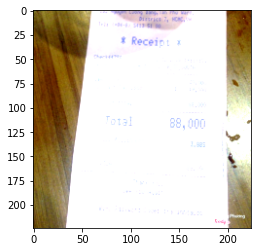

0
class: ['highlands', 'others', 'phuclong', 'starbucks']
kich thuoc anh:  torch.Size([3, 224, 224])
len train:  482
len test:  138
len batch train:  61
device: cuda
---------------------------------------------------------------
Epoch 0 step 9 average_loss 1.0664
Epoch 0 step 19 average_loss 1.0104
Epoch 0 step 29 average_loss 0.4492
Epoch 0 step 39 average_loss 1.9284
Epoch 0 step 49 average_loss 1.4601
Epoch 0 step 59 average_loss 1.2190
              precision    recall  f1-score   support

   highlands       0.00      0.00      0.00        40
      others       0.00      0.00      0.00        18
    phuclong       0.29      1.00      0.45        40
   starbucks       0.00      0.00      0.00        40

    accuracy                           0.29       138
   macro avg       0.07      0.25      0.11       138
weighted avg       0.08      0.29      0.13       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 1 step 9 average_loss 2.5914
Epoch 1 step 19 average_loss 1.9972
Epoch 1 step 29 average_loss 1.4562
Epoch 1 step 39 average_loss 2.4491
Epoch 1 step 49 average_loss 1.8482
Epoch 1 step 59 average_loss 2.5422
              precision    recall  f1-score   support

   highlands       0.00      0.00      0.00        40
      others       0.00      0.00      0.00        18
    phuclong       0.39      0.65      0.49        40
   starbucks       0.34      0.60      0.43        40

    accuracy                           0.36       138
   macro avg       0.18      0.31      0.23       138
weighted avg       0.21      0.36      0.27       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 2 step 9 average_loss 3.6976
Epoch 2 step 19 average_loss 2.6101
Epoch 2 step 29 average_loss 1.9396
Epoch 2 step 39 average_loss 1.6598
Epoch 2 step 49 average_loss 1.0858
Epoch 2 step 59 average_loss 0.9353
              precision    recall  f1-score   support

   highlands       0.63      0.93      0.75        40
      others       1.00      0.28      0.43        18
    phuclong       0.83      0.12      0.22        40
   starbucks       0.54      0.93      0.69        40

    accuracy                           0.61       138
   macro avg       0.75      0.56      0.52       138
weighted avg       0.71      0.61      0.53       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 9 average_loss 0.6634
Epoch 3 step 19 average_loss 1.2005
Epoch 3 step 29 average_loss 1.5457
Epoch 3 step 39 average_loss 0.7442
Epoch 3 step 49 average_loss 1.0429
Epoch 3 step 59 average_loss 1.3012
              precision    recall  f1-score   support

   highlands       0.44      0.95      0.60        40
      others       1.00      0.11      0.20        18
    phuclong       0.67      0.65      0.66        40
   starbucks       0.73      0.20      0.31        40

    accuracy                           0.54       138
   macro avg       0.71      0.48      0.44       138
weighted avg       0.66      0.54      0.48       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 9 average_loss 1.7442
Epoch 4 step 19 average_loss 0.6783
Epoch 4 step 29 average_loss 1.2401
Epoch 4 step 39 average_loss 0.8034
Epoch 4 step 49 average_loss 0.4859
Epoch 4 step 59 average_loss 1.2278
              precision    recall  f1-score   support

   highlands       0.41      1.00      0.58        40
      others       0.71      0.94      0.81        18
    phuclong       1.00      0.20      0.33        40
   starbucks       0.50      0.10      0.17        40

    accuracy                           0.50       138
   macro avg       0.65      0.56      0.47       138
weighted avg       0.65      0.50      0.42       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 9 average_loss 1.2496
Epoch 5 step 19 average_loss 0.9957
Epoch 5 step 29 average_loss 0.9867
Epoch 5 step 39 average_loss 0.4034
Epoch 5 step 49 average_loss 0.4166
Epoch 5 step 59 average_loss 1.2799
              precision    recall  f1-score   support

   highlands       0.62      0.95      0.75        40
      others       0.76      0.72      0.74        18
    phuclong       1.00      0.57      0.73        40
   starbucks       0.86      0.80      0.83        40

    accuracy                           0.77       138
   macro avg       0.81      0.76      0.76       138
weighted avg       0.82      0.77      0.77       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 9 average_loss 0.7208
Epoch 6 step 19 average_loss 0.4543
Epoch 6 step 29 average_loss 0.4349
Epoch 6 step 39 average_loss 0.6587
Epoch 6 step 49 average_loss 0.3981
Epoch 6 step 59 average_loss 0.3545
              precision    recall  f1-score   support

   highlands       0.86      0.95      0.90        40
      others       0.93      0.78      0.85        18
    phuclong       1.00      0.90      0.95        40
   starbucks       0.91      0.97      0.94        40

    accuracy                           0.92       138
   macro avg       0.93      0.90      0.91       138
weighted avg       0.92      0.92      0.92       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 9 average_loss 0.7630
Epoch 7 step 19 average_loss 0.2929
Epoch 7 step 29 average_loss 1.2187
Epoch 7 step 39 average_loss 0.5126
Epoch 7 step 49 average_loss 0.9504
Epoch 7 step 59 average_loss 0.3392
              precision    recall  f1-score   support

   highlands       0.78      1.00      0.88        40
      others       0.88      0.83      0.86        18
    phuclong       1.00      0.82      0.90        40
   starbucks       0.97      0.90      0.94        40

    accuracy                           0.90       138
   macro avg       0.91      0.89      0.89       138
weighted avg       0.91      0.90      0.90       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 step 9 average_loss 0.2986
Epoch 8 step 19 average_loss 0.3480
Epoch 8 step 29 average_loss 0.2931
Epoch 8 step 39 average_loss 0.2254
Epoch 8 step 49 average_loss 0.1100
Epoch 8 step 59 average_loss 0.2296
              precision    recall  f1-score   support

   highlands       0.85      1.00      0.92        40
      others       0.88      0.78      0.82        18
    phuclong       1.00      0.82      0.90        40
   starbucks       0.90      0.95      0.93        40

    accuracy                           0.91       138
   macro avg       0.91      0.89      0.89       138
weighted avg       0.91      0.91      0.90       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 step 9 average_loss 0.4846
Epoch 9 step 19 average_loss 0.5042
Epoch 9 step 29 average_loss 0.2092
Epoch 9 step 39 average_loss 0.9845
Epoch 9 step 49 average_loss 0.5382
Epoch 9 step 59 average_loss 0.3498
              precision    recall  f1-score   support

   highlands       0.68      1.00      0.81        40
      others       0.93      0.72      0.81        18
    phuclong       1.00      0.65      0.79        40
   starbucks       0.95      0.93      0.94        40

    accuracy                           0.84       138
   macro avg       0.89      0.82      0.84       138
weighted avg       0.88      0.84      0.84       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 step 9 average_loss 0.2418
Epoch 10 step 19 average_loss 0.4605
Epoch 10 step 29 average_loss 0.2280
Epoch 10 step 39 average_loss 0.2049
Epoch 10 step 49 average_loss 0.6369
Epoch 10 step 59 average_loss 0.1873
              precision    recall  f1-score   support

   highlands       0.92      0.82      0.87        40
      others       0.69      1.00      0.82        18
    phuclong       0.92      0.85      0.88        40
   starbucks       0.95      0.93      0.94        40

    accuracy                           0.88       138
   macro avg       0.87      0.90      0.88       138
weighted avg       0.90      0.88      0.89       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 step 9 average_loss 0.4960
Epoch 11 step 19 average_loss 0.2808
Epoch 11 step 29 average_loss 0.8550
Epoch 11 step 39 average_loss 0.3859
Epoch 11 step 49 average_loss 0.2572
Epoch 11 step 59 average_loss 0.2323
              precision    recall  f1-score   support

   highlands       0.85      1.00      0.92        40
      others       0.95      1.00      0.97        18
    phuclong       1.00      0.90      0.95        40
   starbucks       1.00      0.90      0.95        40

    accuracy                           0.94       138
   macro avg       0.95      0.95      0.95       138
weighted avg       0.95      0.94      0.94       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 step 9 average_loss 0.2686
Epoch 12 step 19 average_loss 0.6689
Epoch 12 step 29 average_loss 0.6769
Epoch 12 step 39 average_loss 0.4599
Epoch 12 step 49 average_loss 0.2826
Epoch 12 step 59 average_loss 0.1502
              precision    recall  f1-score   support

   highlands       0.93      0.93      0.93        40
      others       1.00      0.72      0.84        18
    phuclong       0.58      0.95      0.72        40
   starbucks       0.84      0.40      0.54        40

    accuracy                           0.75       138
   macro avg       0.84      0.75      0.76       138
weighted avg       0.81      0.75      0.74       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 step 9 average_loss 1.1146
Epoch 13 step 19 average_loss 0.5081
Epoch 13 step 29 average_loss 0.6483
Epoch 13 step 39 average_loss 0.4658
Epoch 13 step 49 average_loss 0.5495
Epoch 13 step 59 average_loss 0.1219
              precision    recall  f1-score   support

   highlands       0.78      1.00      0.88        40
      others       0.68      0.94      0.79        18
    phuclong       1.00      0.60      0.75        40
   starbucks       0.97      0.93      0.95        40

    accuracy                           0.86       138
   macro avg       0.86      0.87      0.84       138
weighted avg       0.89      0.86      0.85       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 step 9 average_loss 0.0964
Epoch 14 step 19 average_loss 0.1011
Epoch 14 step 29 average_loss 0.1805
Epoch 14 step 39 average_loss 0.0609
Epoch 14 step 49 average_loss 0.1537
Epoch 14 step 59 average_loss 0.1361
              precision    recall  f1-score   support

   highlands       0.82      1.00      0.90        40
      others       0.94      0.83      0.88        18
    phuclong       1.00      0.90      0.95        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.93       138
   macro avg       0.94      0.91      0.92       138
weighted avg       0.94      0.93      0.93       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 step 9 average_loss 0.4489
Epoch 15 step 19 average_loss 0.1068
Epoch 15 step 29 average_loss 0.1042
Epoch 15 step 39 average_loss 0.2812
Epoch 15 step 49 average_loss 0.5473
Epoch 15 step 59 average_loss 0.4195
              precision    recall  f1-score   support

   highlands       0.80      1.00      0.89        40
      others       0.60      1.00      0.75        18
    phuclong       1.00      0.53      0.69        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.84       138
   macro avg       0.85      0.86      0.82       138
weighted avg       0.89      0.84      0.83       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 step 9 average_loss 0.8974
Epoch 16 step 19 average_loss 0.3130
Epoch 16 step 29 average_loss 0.1686
Epoch 16 step 39 average_loss 0.0597
Epoch 16 step 49 average_loss 0.2464
Epoch 16 step 59 average_loss 0.1971
              precision    recall  f1-score   support

   highlands       1.00      0.90      0.95        40
      others       0.35      1.00      0.52        18
    phuclong       0.96      0.60      0.74        40
   starbucks       1.00      0.65      0.79        40

    accuracy                           0.75       138
   macro avg       0.83      0.79      0.75       138
weighted avg       0.90      0.75      0.79       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 step 9 average_loss 0.0731
Epoch 17 step 19 average_loss 0.0816
Epoch 17 step 29 average_loss 0.0960
Epoch 17 step 39 average_loss 0.0763
Epoch 17 step 49 average_loss 0.0783
Epoch 17 step 59 average_loss 0.0198
              precision    recall  f1-score   support

   highlands       0.89      1.00      0.94        40
      others       0.89      0.94      0.92        18
    phuclong       1.00      0.93      0.96        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.95       138
   macro avg       0.95      0.95      0.95       138
weighted avg       0.95      0.95      0.95       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 step 9 average_loss 0.0168
Epoch 18 step 19 average_loss 0.0485
Epoch 18 step 29 average_loss 0.1253
Epoch 18 step 39 average_loss 0.4127
Epoch 18 step 49 average_loss 0.1480
Epoch 18 step 59 average_loss 0.1121
              precision    recall  f1-score   support

   highlands       0.95      0.97      0.96        40
      others       0.94      0.94      0.94        18
    phuclong       0.93      0.97      0.95        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.96       138
   macro avg       0.96      0.95      0.95       138
weighted avg       0.96      0.96      0.96       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 step 9 average_loss 0.0427
Epoch 19 step 19 average_loss 0.1825
Epoch 19 step 29 average_loss 0.0601
Epoch 19 step 39 average_loss 0.0650
Epoch 19 step 49 average_loss 0.1094
Epoch 19 step 59 average_loss 0.0711
              precision    recall  f1-score   support

   highlands       0.93      1.00      0.96        40
      others       0.90      1.00      0.95        18
    phuclong       0.97      0.93      0.95        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.96       138
   macro avg       0.95      0.96      0.96       138
weighted avg       0.96      0.96      0.96       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 20 step 9 average_loss 0.0188
Epoch 20 step 19 average_loss 0.0503
Epoch 20 step 29 average_loss 0.2054
Epoch 20 step 39 average_loss 0.1570
Epoch 20 step 49 average_loss 0.1067
Epoch 20 step 59 average_loss 0.0575
              precision    recall  f1-score   support

   highlands       1.00      1.00      1.00        40
      others       0.95      1.00      0.97        18
    phuclong       0.97      0.97      0.97        40
   starbucks       1.00      0.97      0.99        40

    accuracy                           0.99       138
   macro avg       0.98      0.99      0.98       138
weighted avg       0.99      0.99      0.99       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 21 step 9 average_loss 0.0356
Epoch 21 step 19 average_loss 0.0123
Epoch 21 step 29 average_loss 0.1505
Epoch 21 step 39 average_loss 0.0799
Epoch 21 step 49 average_loss 0.0786
Epoch 21 step 59 average_loss 0.0765
              precision    recall  f1-score   support

   highlands       0.98      1.00      0.99        40
      others       0.90      1.00      0.95        18
    phuclong       0.95      0.95      0.95        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.96       138
   macro avg       0.96      0.97      0.96       138
weighted avg       0.97      0.96      0.96       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 22 step 9 average_loss 0.0136
Epoch 22 step 19 average_loss 0.0716
Epoch 22 step 29 average_loss 0.0116
Epoch 22 step 39 average_loss 0.1116
Epoch 22 step 49 average_loss 0.0960
Epoch 22 step 59 average_loss 0.1963
              precision    recall  f1-score   support

   highlands       0.81      0.75      0.78        40
      others       0.84      0.89      0.86        18
    phuclong       0.97      0.70      0.81        40
   starbucks       0.66      0.88      0.75        40

    accuracy                           0.79       138
   macro avg       0.82      0.80      0.80       138
weighted avg       0.82      0.79      0.79       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 23 step 9 average_loss 0.7840
Epoch 23 step 19 average_loss 0.4897
Epoch 23 step 29 average_loss 0.3440
Epoch 23 step 39 average_loss 0.1676
Epoch 23 step 49 average_loss 0.3715
Epoch 23 step 59 average_loss 0.1932
              precision    recall  f1-score   support

   highlands       0.91      1.00      0.95        40
      others       0.89      0.94      0.92        18
    phuclong       1.00      0.85      0.92        40
   starbucks       0.93      0.95      0.94        40

    accuracy                           0.93       138
   macro avg       0.93      0.94      0.93       138
weighted avg       0.94      0.93      0.93       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 24 step 9 average_loss 0.2374
Epoch 24 step 19 average_loss 0.1432
Epoch 24 step 29 average_loss 0.1736
Epoch 24 step 39 average_loss 0.1487
Epoch 24 step 49 average_loss 0.1984
Epoch 24 step 59 average_loss 0.1054
              precision    recall  f1-score   support

   highlands       0.89      1.00      0.94        40
      others       0.89      0.94      0.92        18
    phuclong       1.00      0.93      0.96        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.95       138
   macro avg       0.95      0.95      0.95       138
weighted avg       0.95      0.95      0.95       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 25 step 9 average_loss 0.0623
Epoch 25 step 19 average_loss 0.0190
Epoch 25 step 29 average_loss 0.0290
Epoch 25 step 39 average_loss 0.0839
Epoch 25 step 49 average_loss 0.0063
Epoch 25 step 59 average_loss 0.0736
              precision    recall  f1-score   support

   highlands       0.87      1.00      0.93        40
      others       0.89      0.94      0.92        18
    phuclong       1.00      0.90      0.95        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.94       138
   macro avg       0.94      0.94      0.94       138
weighted avg       0.95      0.94      0.94       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 26 step 9 average_loss 0.0050
Epoch 26 step 19 average_loss 0.0091
Epoch 26 step 29 average_loss 0.0119
Epoch 26 step 39 average_loss 0.0334
Epoch 26 step 49 average_loss 0.0933
Epoch 26 step 59 average_loss 0.1520
              precision    recall  f1-score   support

   highlands       0.95      1.00      0.98        40
      others       0.94      0.94      0.94        18
    phuclong       0.93      0.95      0.94        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.96       138
   macro avg       0.96      0.95      0.95       138
weighted avg       0.96      0.96      0.96       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 27 step 9 average_loss 0.2141
Epoch 27 step 19 average_loss 0.0568
Epoch 27 step 29 average_loss 0.0475
Epoch 27 step 39 average_loss 0.0443
Epoch 27 step 49 average_loss 0.0236
Epoch 27 step 59 average_loss 0.1523
              precision    recall  f1-score   support

   highlands       0.89      1.00      0.94        40
      others       0.85      0.94      0.89        18
    phuclong       0.97      0.85      0.91        40
   starbucks       0.97      0.93      0.95        40

    accuracy                           0.93       138
   macro avg       0.92      0.93      0.92       138
weighted avg       0.93      0.93      0.93       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 28 step 9 average_loss 0.0098
Epoch 28 step 19 average_loss 0.0203
Epoch 28 step 29 average_loss 0.0288
Epoch 28 step 39 average_loss 0.0838
Epoch 28 step 49 average_loss 0.0659
Epoch 28 step 59 average_loss 0.0204
              precision    recall  f1-score   support

   highlands       0.85      1.00      0.92        40
      others       1.00      0.94      0.97        18
    phuclong       0.97      0.88      0.92        40
   starbucks       0.95      0.90      0.92        40

    accuracy                           0.93       138
   macro avg       0.94      0.93      0.93       138
weighted avg       0.93      0.93      0.93       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 29 step 9 average_loss 0.2570
Epoch 29 step 19 average_loss 0.0701
Epoch 29 step 29 average_loss 0.1536
Epoch 29 step 39 average_loss 0.1319
Epoch 29 step 49 average_loss 0.3466
Epoch 29 step 59 average_loss 0.0428
              precision    recall  f1-score   support

   highlands       0.93      1.00      0.96        40
      others       0.94      0.94      0.94        18
    phuclong       0.82      0.93      0.87        40
   starbucks       0.97      0.78      0.86        40

    accuracy                           0.91       138
   macro avg       0.92      0.91      0.91       138
weighted avg       0.91      0.91      0.90       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 30 step 9 average_loss 0.1540
Epoch 30 step 19 average_loss 0.0375
Epoch 30 step 29 average_loss 0.0585
Epoch 30 step 39 average_loss 0.0164
Epoch 30 step 49 average_loss 0.1087
Epoch 30 step 59 average_loss 0.0545
              precision    recall  f1-score   support

   highlands       0.89      1.00      0.94        40
      others       0.95      1.00      0.97        18
    phuclong       1.00      0.95      0.97        40
   starbucks       1.00      0.90      0.95        40

    accuracy                           0.96       138
   macro avg       0.96      0.96      0.96       138
weighted avg       0.96      0.96      0.96       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 31 step 9 average_loss 0.1004
Epoch 31 step 19 average_loss 0.0415
Epoch 31 step 29 average_loss 0.0174
Epoch 31 step 39 average_loss 0.0211
Epoch 31 step 49 average_loss 0.0123
Epoch 31 step 59 average_loss 0.0194
              precision    recall  f1-score   support

   highlands       1.00      1.00      1.00        40
      others       0.90      1.00      0.95        18
    phuclong       0.93      0.95      0.94        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.96       138
   macro avg       0.96      0.97      0.96       138
weighted avg       0.97      0.96      0.96       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 32 step 9 average_loss 0.0006
Epoch 32 step 19 average_loss 0.0018
Epoch 32 step 29 average_loss 0.0142
Epoch 32 step 39 average_loss 0.0028
Epoch 32 step 49 average_loss 0.0034
Epoch 32 step 59 average_loss 0.0146
              precision    recall  f1-score   support

   highlands       1.00      1.00      1.00        40
      others       0.95      1.00      0.97        18
    phuclong       0.93      0.97      0.95        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.97       138
   macro avg       0.97      0.98      0.97       138
weighted avg       0.97      0.97      0.97       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 33 step 9 average_loss 0.0010
Epoch 33 step 19 average_loss 0.0264
Epoch 33 step 29 average_loss 0.0030
Epoch 33 step 39 average_loss 0.0462
Epoch 33 step 49 average_loss 0.0151
Epoch 33 step 59 average_loss 0.0820
              precision    recall  f1-score   support

   highlands       1.00      1.00      1.00        40
      others       0.82      1.00      0.90        18
    phuclong       0.93      0.93      0.93        40
   starbucks       1.00      0.90      0.95        40

    accuracy                           0.95       138
   macro avg       0.94      0.96      0.94       138
weighted avg       0.95      0.95      0.95       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 34 step 9 average_loss 0.0242
Epoch 34 step 19 average_loss 0.1541
Epoch 34 step 29 average_loss 0.0965
Epoch 34 step 39 average_loss 0.0286
Epoch 34 step 49 average_loss 0.0825
Epoch 34 step 59 average_loss 0.1898
              precision    recall  f1-score   support

   highlands       0.91      1.00      0.95        40
      others       1.00      0.78      0.88        18
    phuclong       0.92      0.88      0.90        40
   starbucks       0.93      0.97      0.95        40

    accuracy                           0.93       138
   macro avg       0.94      0.91      0.92       138
weighted avg       0.93      0.93      0.93       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 35 step 9 average_loss 0.0793
Epoch 35 step 19 average_loss 0.2608
Epoch 35 step 29 average_loss 0.0280
Epoch 35 step 39 average_loss 0.1865
Epoch 35 step 49 average_loss 0.0210
Epoch 35 step 59 average_loss 0.0572
              precision    recall  f1-score   support

   highlands       0.87      1.00      0.93        40
      others       0.89      0.89      0.89        18
    phuclong       1.00      0.93      0.96        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.94       138
   macro avg       0.94      0.93      0.94       138
weighted avg       0.95      0.94      0.94       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 36 step 9 average_loss 0.9409
Epoch 36 step 19 average_loss 0.0689
Epoch 36 step 29 average_loss 0.2809
Epoch 36 step 39 average_loss 0.0666
Epoch 36 step 49 average_loss 0.0994
Epoch 36 step 59 average_loss 0.1029
              precision    recall  f1-score   support

   highlands       0.97      0.93      0.95        40
      others       0.69      1.00      0.82        18
    phuclong       0.97      0.90      0.94        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.93       138
   macro avg       0.91      0.94      0.92       138
weighted avg       0.94      0.93      0.93       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 37 step 9 average_loss 0.2458
Epoch 37 step 19 average_loss 0.1291
Epoch 37 step 29 average_loss 0.1553
Epoch 37 step 39 average_loss 0.1526
Epoch 37 step 49 average_loss 0.0613
Epoch 37 step 59 average_loss 0.0155
              precision    recall  f1-score   support

   highlands       0.95      1.00      0.98        40
      others       0.90      1.00      0.95        18
    phuclong       0.95      0.93      0.94        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.96       138
   macro avg       0.95      0.96      0.96       138
weighted avg       0.96      0.96      0.96       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 38 step 9 average_loss 0.0144
Epoch 38 step 19 average_loss 0.0112
Epoch 38 step 29 average_loss 0.0076
Epoch 38 step 39 average_loss 0.0124
Epoch 38 step 49 average_loss 0.1370
Epoch 38 step 59 average_loss 0.1018
              precision    recall  f1-score   support

   highlands       0.63      0.97      0.76        40
      others       0.88      0.78      0.82        18
    phuclong       1.00      0.55      0.71        40
   starbucks       0.95      0.90      0.92        40

    accuracy                           0.80       138
   macro avg       0.86      0.80      0.81       138
weighted avg       0.86      0.80      0.80       138

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 39 step 9 average_loss 0.0841
Epoch 39 step 19 average_loss 0.0756
Epoch 39 step 29 average_loss 0.1494
Epoch 39 step 39 average_loss 0.0192
Epoch 39 step 49 average_loss 0.1421
Epoch 39 step 59 average_loss 0.0455
              precision    recall  f1-score   support

   highlands       0.98      1.00      0.99        40
      others       0.95      1.00      0.97        18
    phuclong       0.95      0.97      0.96        40
   starbucks       1.00      0.93      0.96        40

    accuracy                           0.97       138
   macro avg       0.97      0.98      0.97       138
weighted avg       0.97      0.97      0.97       138

accracy:  [28, 36, 60, 53, 50, 76, 92, 89, 90, 84, 88, 94, 75, 85, 92, 84, 75, 94, 95, 95, 98, 96, 78, 93, 94, 94, 95, 92, 92, 90, 95, 96, 97, 94, 92, 94, 92, 95, 80, 97]
loss:  [3.3863, 0.4534, 2.5378, 3.0809, 4.4503, 5.788, 8.9136, 0.0025, 0.8471, 0.0478, 1.2418, 4.2404, 13.3096, 0.3683, 0.6593, 0.3124, 0.0238, 0.0001, 0.0081, 0.0003, 0.003

In [84]:
datasets = prepare_data()
loader = prepare_loader(datasets)
imshow(datasets.test[21][0])
print(datasets.test[21][1])
print("class:", datasets.train.classes)
model = main()

#run train

In [85]:
#test
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

modeldir = '/content/model.pth'
sample_test_thay = '/content/drive/MyDrive/kì_1_4/Xu_ly_anh/Thay_cuong/gk/Code/simpleOCR_trinh/sampledata_thay'


In [86]:
#load model
model = torchvision.models.resnet18(pretrained=True)

model.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=4, bias=True)

#connect GPU
model.to(device)

#???
model.load_state_dict(torch.load(modeldir, map_location=device))

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
#transforms
img_transforms = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [91]:
images = os.listdir(sample_test_thay) #list of image test cua thay
images.sort()

In [100]:
ypred = []

#duyệt các ảnh trong file ảnh test của thầy
for image_name in images:
  path = os.path.join(sample_test_thay, image_name)
  image = Image.open(path)  #mở ảnh 
  image = img_transforms(image) #chuyển dạng ảnh
  image = np.transpose(image, (0,1,2)) #???
  image = image.unsqueeze(0) 
  image = image.to(device)

  model.eval()

  with torch.no_grad():
    output = model(image)     #
    _, predicted = torch.max(output, dim=1)
    ypred += (list(predicted.cpu().numpy()))

    print(image_name)
    print(classes[int(predicted.cpu().numpy())])
    print("-------------------")


img1.jpeg
highlands
-------------------
img10.jpeg
others
-------------------
img11.jpg
starbucks
-------------------
img2.jpeg
highlands
-------------------
img3.jpeg
highlands
-------------------
img4.jpeg
phuclong
-------------------
img5.jpeg
phuclong
-------------------
img6.jpeg
starbucks
-------------------
img7.jpeg
others
-------------------
img8.jpeg
highlands
-------------------
img9.jpeg
others
-------------------
